In [1]:
import sys
sys.path.append("../")  

import numpy as np 
import math, torch, time
import matplotlib.pyplot as plt
import sys
import problem
import random
import net
from scipy.linalg import lstsq

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

# 设置随机种子
set_seed(42)
plt.rcParams.update({'font.size': 20})

In [2]:
from scipy.linalg import lstsq
def trainnew(model,problem,device,params,optimizer):
    problem.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
    int_data = problem.data()["interior_points"]
    bdry_data = problem.data()["boundary_points"]
    initial_data = problem.data()["initial_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True
    initial_data.requires_grad = True
    ranks = []
    singular_values = []
    initialloss = 1
    model.train()
    for step in range(params["trainStep"]):
        u = model(int_data)[1]
        u = u.squeeze(1) if len(u.shape) == 2 else u
        u_second = model(int_data)[0]
        u_bdry = model(bdry_data)[1]
        u_bdry = u_bdry.squeeze(1) if len(u_bdry.shape) == 2 else u_bdry
        u_init = model(initial_data)[1]
        u_init = u_init.squeeze(1) if len(u_init.shape) == 2 else u_init
        model.zero_grad()
        loss_int = problem.loss_int(u, int_data)
        loss_bdry = problem.loss_bdry(u_bdry, bdry_data)
        loss_init = problem.loss_init(u_init, initial_data)
        loss_orthogonal = torch.norm(u_second.T @ u_second - torch.eye(params["width"]).to(device).double(), p='fro')
        loss = loss_int + loss_orthogonal*params["orthogonalpenalty"] + params["beta"]*loss_bdry + params["alpha"]*loss_init
        
        if step == 1:
            initialloss = (loss_int+ params["beta"]*loss_bdry + params["alpha"]*loss_init).detach().cpu().numpy()
            print("Initial loss is %s"%(initialloss))
        else:
            if (loss_int+ params["beta"]*loss_bdry + params["alpha"]*loss_init).detach().cpu().numpy()/initialloss < params["epsilon"]:
                print("Error at Step %s is %s"%(step+1,loss_int.detach().cpu().numpy()))
                break

        if step%params["writeStep"] == params["writeStep"]-1:
            rank = torch.linalg.matrix_rank(u_second, tol=0.001)
            ranks.append(rank.cpu().numpy())
            print("Error at Step %s is %s with interior loss %s, boundary loss %s, initial loss %s, orthogonal loss %s and rank of matrix %s."%(step+1,loss.detach().cpu().numpy(),loss_int.detach().cpu().numpy(),loss_bdry.detach().cpu().numpy(),loss_init.detach().cpu().numpy(),loss_orthogonal.detach().cpu().numpy(),rank.cpu().numpy()))
            
        
        if step%params["plotStep"] == params["plotStep"]-1:
            tem = lambda x: model(x)[1]
            problem.plot(tem)
            
        loss.backward()
        optimizer.step()
        
    print("after least squares")
    basis = lambda x: model(x)[0]
    (A, rhs) = problem.leastsquareproblem(basis, int_data, bdry_data, initial_data)
    w, _, _, _ = lstsq(A, rhs)
    U, s, Vh = torch.linalg.svd(u_second.T@u_second)
    error = A @ w - rhs
    threshold = 1e-3
    effective_rank = (s > threshold).sum()
    print("the error of least square in problem " + str(problem.name)+": ", np.mean(np.abs(error)))
    print("the effective rank of basis in problem %s is %s with threshold %s" % (str(problem.name), effective_rank.detach().cpu().numpy(), threshold))
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    problem.plot(perdict)
    return ranks, singular_values

In [3]:
torch.set_default_dtype(torch.float64)
plt.rcParams.update({'font.size': 20})
# Exact solution u(x, t) = 0.5 * (sin(4*pi*x + t) + sin(4*pi*x - t))
def exact_u(points):
    # points: tensor of shape [N, 2], where points[:, 0] = x, points[:, 1] = t
    x = points[:, 0]
    t = points[:, 1]
    return 0.5 * (torch.sin( math.pi * x + t) + torch.sin(math.pi * x - t))

# Initial condition u(x, 0) = sin(4*pi*x)
def initial_displacement_condition(points):
    # points: tensor of shape [N, 2], where points[:, 0] = x, points[:, 1] = t
    x = points[:, 0]
    return torch.sin(math.pi * x)

def initial_speed_condition(points):
    x = points[:, 0]
    return 0*x

### PD-OFM

c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Initial loss is 0.4701253124569454
Error at Step 50 is 5.933096665433802 with interior loss 0.030162317488907957, boundary loss 0.007268640746048842, initial loss 0.33322270792132463, orthogonal loss 55.624429992775205 and rank of matrix 30.
Error at Step 100 is 3.1834761085265395 with interior loss 0.007744599238408563, boundary loss 0.0031376647591719077, initial loss 0.27806376373156305, orthogonal loss 28.94530080797396 and rank of matrix 31.
after least squares
the error of least square in problem wave1d:  6.446768166864917e-11
the effective rank of basis in problem wave1d is 17 with threshold 0.001
the maximum pointwise error in problem wave1d:  1.1801688010626421e-05
the l2 relative error in problem wave1d:  1.9891991947037795e-06


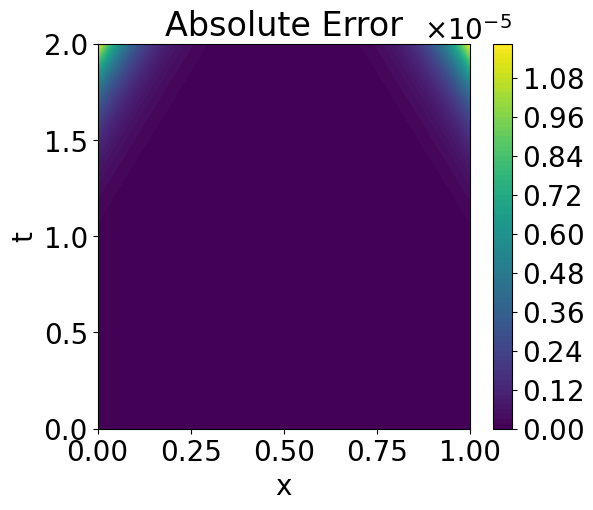

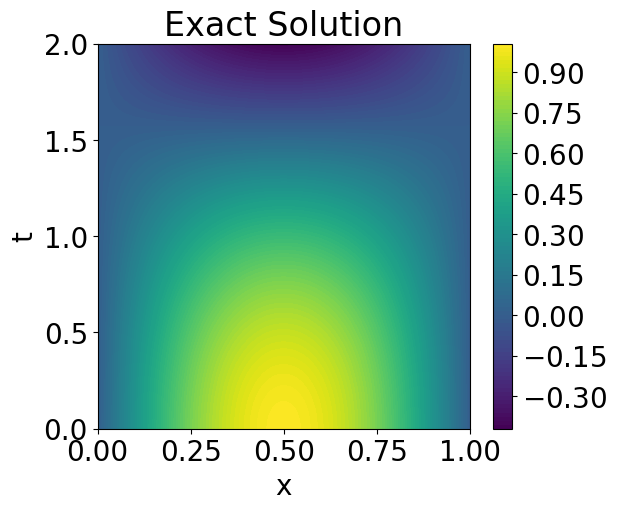

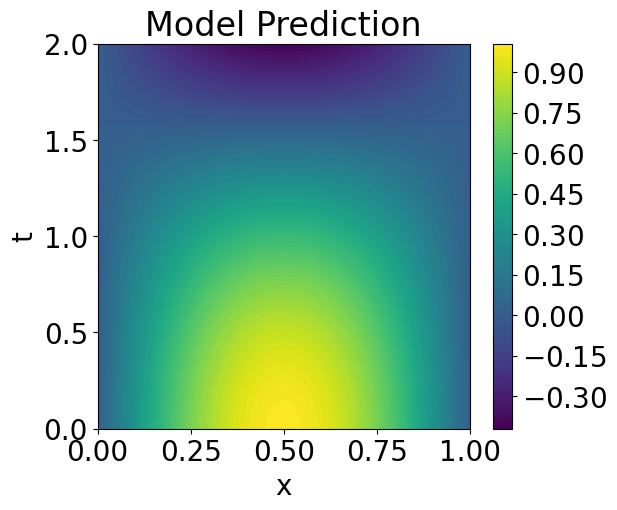

In [4]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.Wave1D(initial_displacement_condition, initial_speed_condition, exact_u, x_range=[0, 1], t_range=[0, 2], wave_speed=1/torch.pi, device=device)

params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 256, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 100, "plotStep": 500, "writeStep": 50, "decay": 0.0001, "lambda": 10, "epsilon": 0, "orthogonalpenalty": 0.1, "beta": 1, "alpha": 1}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = trainnew(model,Pro,device,params,optimizer)

### PD-FM

Initial loss is 0.43497301954321027
Error at Step 50 is 0.08588330884500248 with interior loss 0.00760189164395607, boundary loss 0.031945165064499084, initial loss 0.04633625213654732, orthogonal loss 4040.728005517716 and rank of matrix 29.
Error at Step 100 is 0.004347412254990874 with interior loss 0.0006276135422788949, boundary loss 0.0010995848520479069, initial loss 0.002620213860664072, orthogonal loss 11613.279665353042 and rank of matrix 42.
after least squares
the error of least square in problem wave1d:  1.2523700576461265e-11
the effective rank of basis in problem wave1d is 23 with threshold 0.001
the maximum pointwise error in problem wave1d:  2.7531612553366447e-05
the l2 relative error in problem wave1d:  4.657346050605201e-06


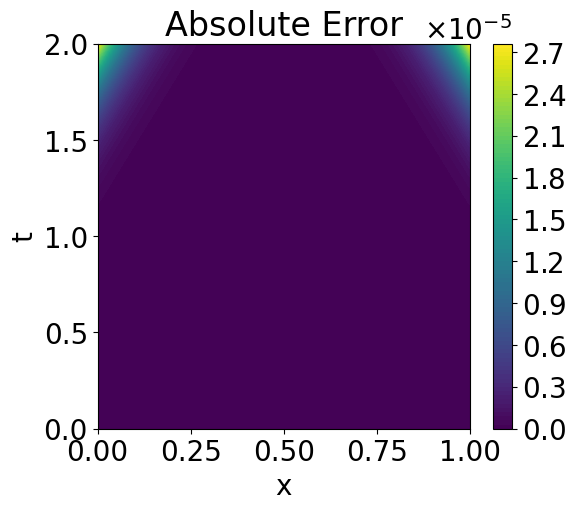

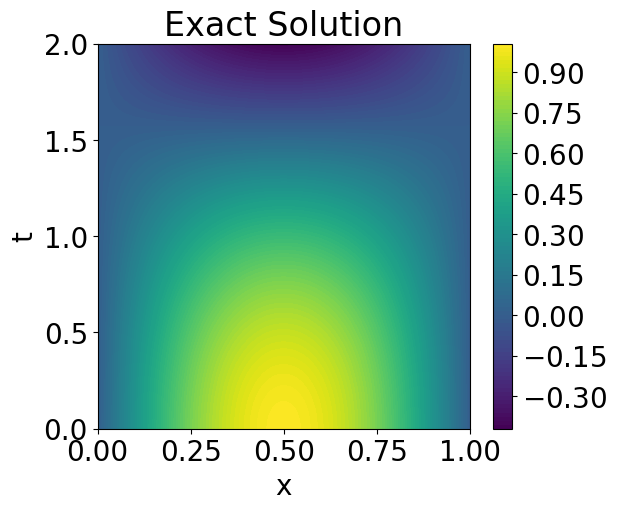

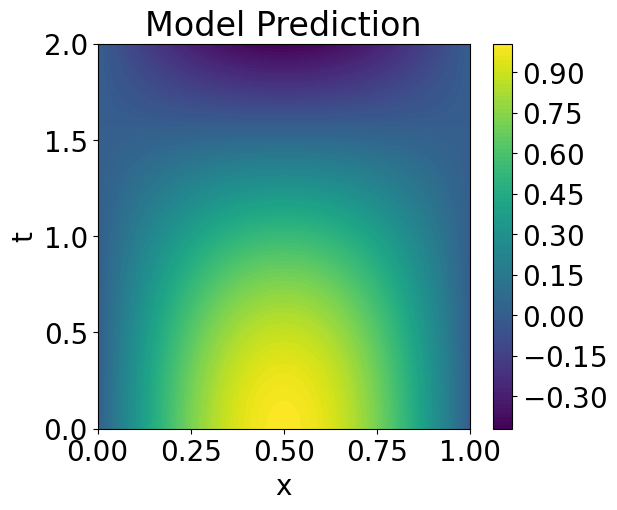

In [5]:
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Pro = problem.Wave1D(initial_displacement_condition, initial_speed_condition, exact_u, x_range=[0, 1], t_range=[0, 2], wave_speed=1/torch.pi, device=device)

params = {"d": 2, "bodyBatch": 1024, "bdryBatch": 256, "lr": 0.001, "width": 500, "depth": 2, "trainStep": 100, "plotStep": 500, "writeStep": 50, "decay": 0.0001, "lambda": 10, "epsilon": 0, "orthogonalpenalty": 0, "beta": 1, "alpha": 1}
startTime = time.time()
model = net.PD_OFM(params).to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])

startTime = time.time()
rank_orthogonal, sigma_orthogonal = trainnew(model,Pro,device,params,optimizer)

Transnet

c:\Users\29433\Desktop\Studying_Materials\2025spring\OrthoPINN\github_code\numerical_experiment\..\net.py:279: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3701.)
  alpha = torch.linalg.lstsq(basis_eval, grf_sample.T).solution  # (basis_num, 1)


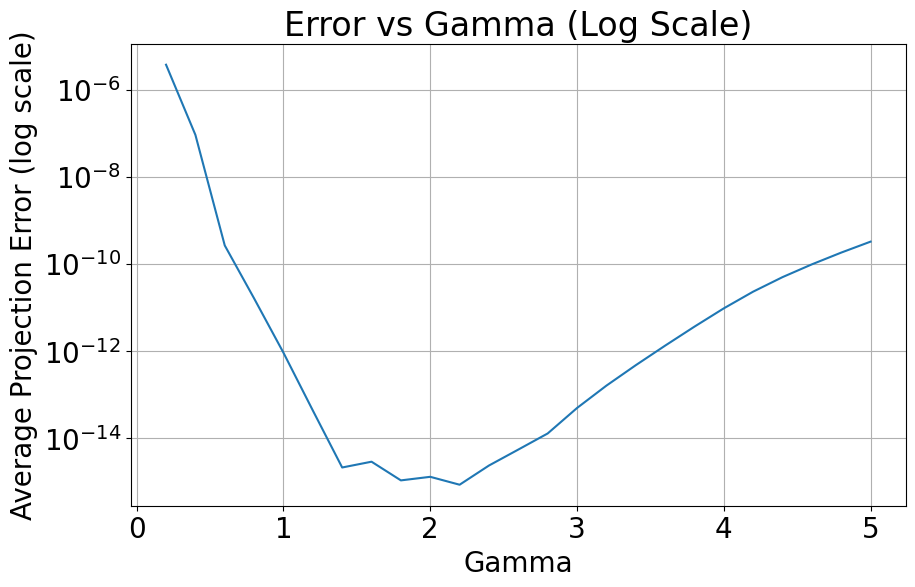

best shape parameter:  2.200000047683716
the error of least square in problem wave1d:  2.7523061915125053e-09
the effective rank of basis in problem wave1d is 51 with threshold 0.001
the maximum pointwise error in problem wave1d:  0.024007298153534862
the l2 relative error in problem wave1d:  0.0044137788462583144


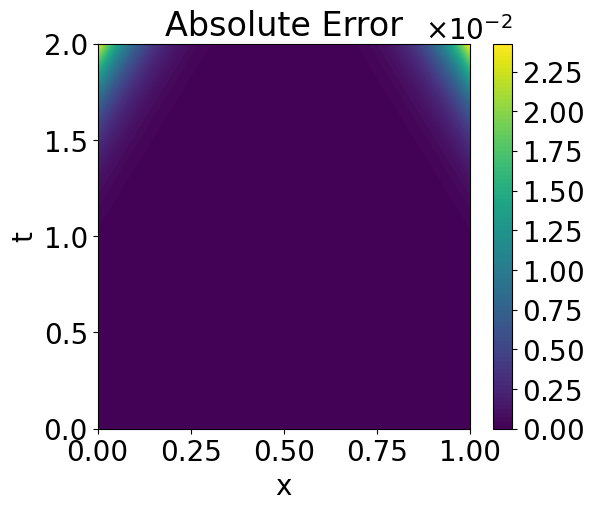

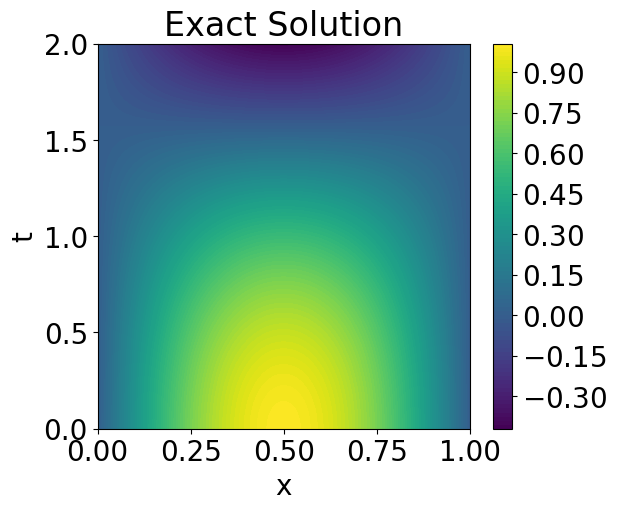

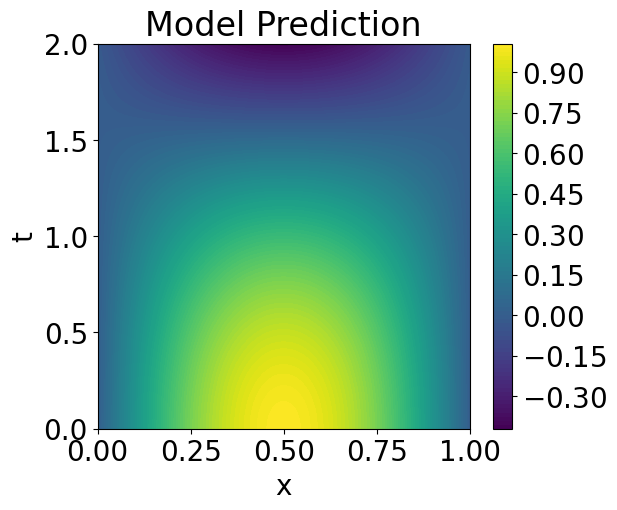

In [6]:
set_seed(42)
device = "cpu"
Pro = problem.Wave1D(initial_displacement_condition, initial_speed_condition, exact_u, x_range=[0, 1], t_range=[0, 2], wave_speed=1/torch.pi, device=device)
params = dict()
params = {"radius": 1.2, "d": 2, "bodyBatch": 1024, "bdryBatch":256, "width": 500}
Pro.generate_points(params["bodyBatch"], params["bdryBatch"], "random")
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
initial_data = Pro.data()["initial_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True
initial_data.requires_grad = True
model = net.TransNet(params["d"], params["width"], params["radius"]).to(device)
print("best shape parameter: ", model.shape_parameter)
model.set_center(torch.tensor([0.5, 1], dtype=torch.float64, device=device))

### Solving Least Sqaure Problem
basis = lambda x: model(x)[0]
(A, rhs) = Pro.leastsquareproblem(basis, int_data, bdry_data, initial_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)

#### Random Feature Method

the error of least square in problem wave1d:  1.091762168097923e-06
the effective rank of basis in problem wave1d is 83 with threshold 0.001
the maximum pointwise error in problem wave1d:  0.06276759665100767
the l2 relative error in problem wave1d:  0.016188238647559885


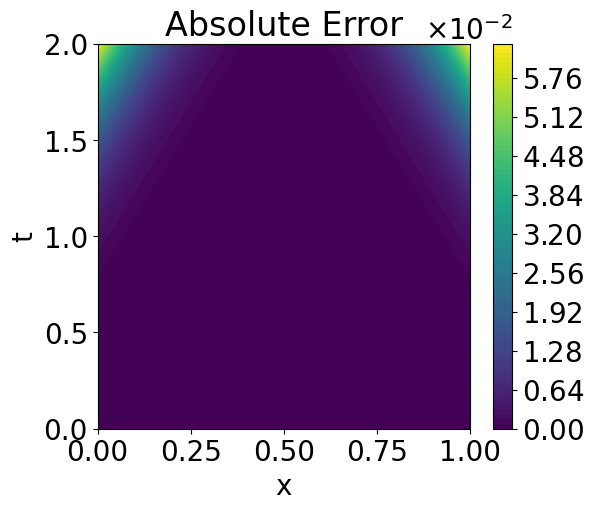

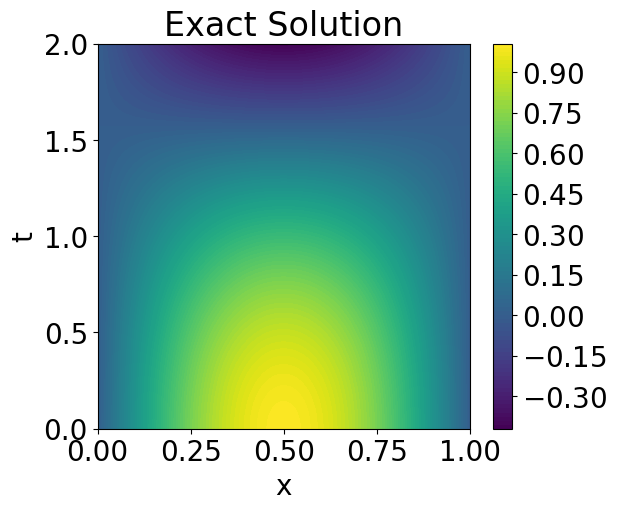

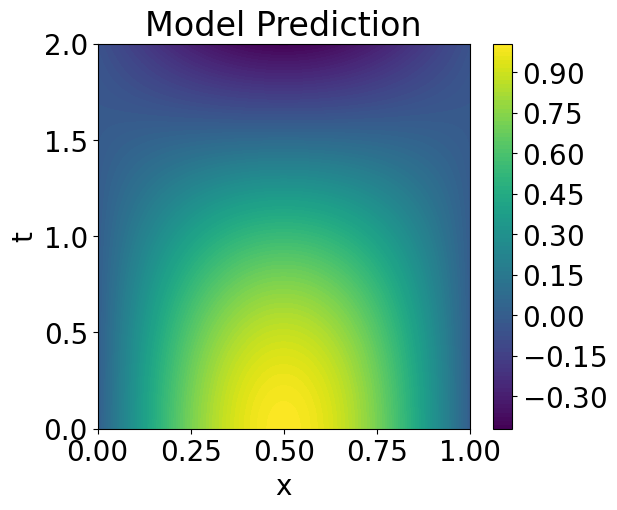

In [7]:
device="cpu"
set_seed(42)

### Initializing RFM and Problem
params = dict()
params = {"d": 2, "bodyBatch": 1024, "bdryBatch":128, "number_basis": 500}
centers = torch.tensor([[0.25,0.5],[0.25,1.5],[0.75,0.5],[0.75,1.5]], dtype=torch.float64).to(device)
radius = torch.tensor([[0.25,0.5],[0.25,0.5],[0.25,0.5],[0.25,0.5]], dtype=torch.float64).to(device)
model = net.RFM(params, centers, radius, typeofPoU="b", device=device).to(device)
Pro = problem.Wave1D(initial_displacement_condition, initial_speed_condition, exact_u, x_range=[0, 1], t_range=[0, 2], wave_speed=1/torch.pi, device=device)
Pro.generate_points(params["bodyBatch"], params["bdryBatch"]) 
int_data = Pro.data()["interior_points"]
bdry_data = Pro.data()["boundary_points"]
initial_data = Pro.data()["initial_points"]
int_data.requires_grad = True
bdry_data.requires_grad = True
initial_data.requires_grad = True

### Solving Least Sqaure Problem
basis = lambda x: model(x)[0]
(A, rhs) = Pro.leastsquareproblem(basis, int_data, bdry_data, initial_data)
w, residuals, rank, s = lstsq(A, rhs)
U, s, Vh = torch.linalg.svd(model(int_data)[0].T@model(int_data)[0])
threshold = 1e-3
effective_rank = (s > threshold).sum()
error = A @ w - rhs
print("the error of least square in problem " + str(Pro.name)+": ", np.mean(np.abs(error)))
print("the effective rank of basis in problem %s is %s with threshold %s" % (str(Pro.name), effective_rank.detach().cpu().numpy(), threshold))

### Visualization
perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
Pro.plot(perdict)
